<a href="https://www.kaggle.com/code/jonathanma02/titanic-dataset?scriptVersionId=101072767" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# finding data set locale
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
combined = [train_df, test_df] 

### Deep Neural Network Implementation for Predicting Titanic Passenger Survivorship
#### Written by Jonathan Ma - 06/17/2022

In [3]:
train_df.tail(5) # Previewing data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# Data Dictionary
| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |  |
| Age | Age in years |  |
| sibsp | # of siblings / spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  | 
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


# Classifying Data
#### Categorical Data
- Ordinal Data: pclass
- Nominal Data: embarked, survived, sex, name


#### Numerical Data
- Discrete Data: age, sibsp, parch
- Continuous Data: fare


#### Mixed Data
- cabin: Latin letter followed by a number
- ticket: Mix of numbers and Latin strings followed by numbers
    

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


**We will drop name, cabin number, and passenger ID from our training examples.**


- Name likely has no bearing on survivorship, and it is unique to every passenger

- Cabin numbers are unusable; out of 891 training examples, 204 have cabin numbers

- Passenger ID is used for Kaggle data submission

### **Preliminary Data Analysis**

In [6]:
train_df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [7]:
train_df[["Sex","Survived"]].groupby(["Sex"], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


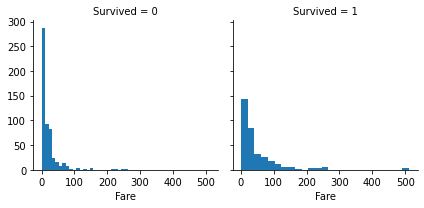

In [8]:
fare_histogram = sns.FacetGrid(train_df, col = "Survived")
fare_histogram.map(plt.hist, "Fare", bins=25)

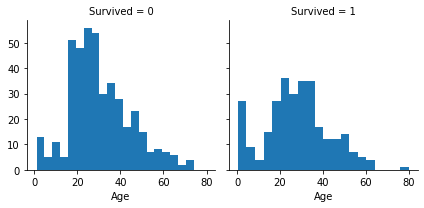

In [9]:
age_histogram = sns.FacetGrid(train_df, col = "Survived")
age_histogram.map(plt.hist, "Age", bins = 20)

In [10]:
train_df[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


With our preliminary data analysis, we have that:


- Gender played a vital role in survivorship in the Titanic (74% of females survived vs. ~19% of males)
- Passenger class also heavily affected survivorship (63% of First class passengers survived vs. 24% in Third class)
- A lower fare correlated to a lower survival rate.
- Infants had a greater chance of survival on the Titanic.
- Port of embarkment played a role in survivorship.


# Feature Engineering

### Motivation:
During the early 20th century, certain titles were a rare commodity amongst commmon folk. Typically, titles such as Dr. or Sir. were reserved for higher class members of society. We will take advantage of the fact that our data set contains names which include titles if a passenger had one, and create a new input feature named "Title." Luckily, this will only take a small amount of globbing, as the titles typically ended with a period.

In [11]:
for i in combined:
    i["Title"] = i["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df["Title"], train_df["Sex"])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We will go ahead and group together the rarer titles in a category called "Exotic". We will also clean up the data by anglicizing the titles.

In [12]:
for i in combined:
    i["Title"] = i["Title"].replace(["Lady", "Countess", "Capt", "Col",
                                     "Don", "Dr", "Major", "Rev", "Sir",
                                     "Jonkheer", "Dona"], "Exotic")
    i["Title"] = i["Title"].replace("Mlle", "Miss")
    i["Title"] = i["Title"].replace("Ms", "Miss")
    i["Title"] = i["Title"].replace("Mme", "Mrs")
    
train_df[["Title", "Survived"]].groupby(["Title"], as_index=False).mean()

,Title,Survived
0,Exotic,0.347826
1,Master,0.575000
2,Miss,0.702703
3,Mr,0.156673
4,Mrs,0.793651


As expected, the feminine titles had higher survival rates, and the more "High Society" titles had higher survival rates than commoner titles. We will convert these categorical titles to ordinal titles by survival rate.

In [13]:
title_map = {"Mr": 1, "Exotic": 2, "Master": 3, "Miss": 4, "Mrs": 5}
for i in combined:
    i["Title"] = i["Title"].map(title_map)
    i["Title"] = i["Title"].fillna(0)
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,4
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,1


We are now going to finish up cleaning up the data. Let's drop some features that we no longer need.

In [14]:
train_df = train_df.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis=1)
test_df = test_df.drop(["Name", "Ticket", "Cabin"], axis=1)
combined = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,5
2,1,3,female,26.0,0,0,7.9250,S,4
3,1,1,female,35.0,1,0,53.1000,S,5
4,0,3,male,35.0,0,0,8.0500,S,1


We will also map Sex onto a boolean function of Female or not Female.

In [15]:
for i in combined:
    i["Sex"] = i["Sex"].map({"female": 1, "male":0}).astype('int')
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,5
2,1,3,1,26.0,0,0,7.9250,S,4
3,1,1,1,35.0,1,0,53.1000,S,5
4,0,3,0,35.0,0,0,8.0500,S,1


# Completing Data
Earlier, we noticed that some of the Age values are missing. We will generate some random numbers (for simplicity sake) between the mean and the standard deviation to quickly fill those missing entries.

In [16]:
age_mean = int(train_df["Age"].mean())
age_std = int(train_df["Age"].std())

for i in combined:
    i.loc[i.Age.isnull(), 'Age'] = np.random.randint(
        age_std, age_mean)
    i["Age"] = i["Age"].astype('int')

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,5
2,1,3,1,26,0,0,7.9250,S,4
3,1,1,1,35,1,0,53.1000,S,5
4,0,3,0,35,0,0,8.0500,S,1


Let's deal with our tumultuous Sibling Count / Parent Count columns. Generally this condenses down to Family Size, so let's combine these categories and perform an analysis.

In [17]:
for i in combined:
    i["FamilySize"] = i["SibSp"] + i["Parch"] + 1

train_df[["FamilySize", "Survived"]].groupby(["FamilySize"], as_index=False).mean().sort_values(by="Survived", ascending=True)

,FamilySize,Survived
7,8,0.000000
8,11,0.000000
5,6,0.136364
4,5,0.200000
0,1,0.303538
6,7,0.333333
1,2,0.552795
2,3,0.578431
3,4,0.724138


It looks like generally there is little correlation between survivorship and family size. Let's dig a little deeper and see if there is correlation between passengers who were alone and passengers who boarded the Titanic with a family.

In [18]:
for i in combined:
    i["Alone"] = 0
    i.loc[i["FamilySize"] == 1, "Alone"] = 1

train_df[["Alone", "Survived"]].groupby(["Alone"], as_index=False).mean()

,Alone,Survived
0,0,0.505650
1,1,0.303538


We see correlation between boarding the Titanic independently and survival. We will keep this final feature and drop Sibling Count and Parent Count.

In [19]:
train_df = train_df.drop(["Parch", "SibSp", "FamilySize"], axis=1)
test_df = test_df.drop(["Parch", "SibSp", "FamilySize"], axis=1)
combined = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Alone
0,0,3,0,22,7.2500,S,1,0
1,1,1,1,38,71.2833,C,5,0
2,1,3,1,26,7.9250,S,4,1
3,1,1,1,35,53.1000,S,5,0
4,0,3,0,35,8.0500,S,1,1


Finally, let's sort embarkment ports by survival rate, and refactor Embarked as ordinal data. In this step, we will also complete our dataset by replacing the two missing embarkment entries with the most common embarkment point.

In [20]:
for i in combined:
    i["Embarked"] = i["Embarked"].fillna(train_df.Embarked.dropna().mode()[0])
train_df[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [21]:
for i in combined:
    i["Embarked"] = i["Embarked"].map({"S": 0, "Q": 1, "C": 2}).astype('int')
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Alone
0,0,3,0,22,7.2500,0,1,0
1,1,1,1,38,71.2833,2,5,0
2,1,3,1,26,7.9250,0,4,1
3,1,1,1,35,53.1000,0,5,0
4,0,3,0,35,8.0500,0,1,1
5,0,3,0,24,8.4583,1,1,1
6,0,1,0,54,51.8625,0,1,1
7,0,3,0,2,21.0750,0,3,0
8,1,3,1,27,11.1333,0,5,0
9,1,2,1,14,30.0708,2,5,0


Finally, this is how our cleaned data set looks like.

# L-Layer Neural Network
Now that we're done with the boring stuff, we can construct our neural network. We're going to do this from scratch.

### ReLU, Sigmoid Functions
Because we are doing a simple binary classification, we will be using the ReLU and Sigmoid functions as our activation functions. 

In [22]:
def sigmoid(Z: np.ndarray):
    return (1/(1+np.exp(-Z)), Z)
def relu(Z: np.ndarray):
    return np.maximum(0, Z), Z

#Our activation helper functions also return a cache value we will use for
#backward propagation

### Forward Propagation
Let's write a few helper function to implement forward propagation.

In [23]:
def linear_forward(A, W, b):
    """
    Implements linear part of a layer's forward propagation
    Args:
    A: Activations from previous layer
    W: Weight matrices
    b: bias vector
    Returns:
    Z: input of the activation function -- pre-activation parameter
    cache -- used for backward propagation
    """

    Z = np.dot(W,A)+b
    cache = (A,W,b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation: str):
    """
    Implements forward propagation for the linear->activation layer
    Args:
    A_prev: Activations from previous layer
    W: Weight matrices
    b: bias vector
    activation: the activation function to be used in this layer, represented by a string
    Returns:
    A: output of the activation function -- post-activation value
    cache -- used for backward propagation
    """ 
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    else:
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

With these functions written, we can write a function which implements forward propagation.

In [24]:
def nn_forward(X, parameters):
    """
    Implements forward propagation for Linear->ReLU *(L-1) -> Linear-> Sigmoid computation
    Args:
    X: Input data
    parameters: dictionary containing all the components necessary for forward propagation
    Returns:
    AL: Activation value from the output layer
    caches: list of caches containing every cache of linear_activation_forward()
    """
    caches = []
    A = X
    L = len(parameters)//2
    
    for i in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)
    return AL, caches

### Cost Function
Let's write a cost function: we will use this formula:
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$

In [25]:
def compute_cost(AL, Y):
    """
    Computes cost of forward propagation.
    Args:
    AL: probability vector -- corresponds to label predictions
    Y: label vector
    Returns:
    cost: vector containing computed cost values
    """
    m = Y.shape[1]
    cost = np.dot(-1/m, np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL), 1-Y)))
    cost = np.squeeze(cost)
    return cost

### Backward Propagation
Almost done with creating our neural network. Let's write some helper functions to tackle backward propagation. 

The partial derivatives with respect to Z (weighted sum of the activations shifted by a bias) of the activation functions are as follows:


### ReLU
$$
\begin{equation}
\partial{J}{\vec{Z}^{[l]}} = \partial{J}{\vec{A}^{[l]}} \odot I(\vec{Z}^{[l]} > 0),
\end{equation}$$

where $\odot$ denotes element-wise mulitplication.

### Sigmoid
$$
\begin{equation}
\partial{J}{\vec{Z}^{[l]}} = \partial{J}{\vec{A}^{[l]}} \odot \vec{A}^{[l]} \odot (1 - \vec{A}^{[l]}).
\end{equation}
$$

We will also be using the following formulas to write our backward propagation functions. 
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$

In [26]:
def d_relu(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True) #converting dZ to the correct object
    dZ[Z <= 0] = 0 #fixing negative values to 0
    return dZ
    

def d_sigmoid(dA, activation_cache):
    Z = activation_cache
    s, temp  = sigmoid(Z)
    dZ = dA * s * (1-s)
    return dZ

def linear_backward(dZ, cache):
    """
    Linear portion of backward propagation for a single layer
    Args:
    dZ: Gradient of the cost with respect to the linear output
    cache: tuple of values(A_prex, W, b) coming from the forward propagation in the current layer
    Returns:
    dA_prev: Gradient of the cost with respect to the activation of the previous layer (l-1)
    dW: Gradient of the cost with respect to W in the current layer
    db: Gradient of the cost with respect to b in the current layer
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(1/m, np.dot(dZ, A_prev.T))
    db = np.dot(1/m, np.sum(dZ, axis=1, keepdims=True))
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implements backward propagation for the Linear -> Activation layer
    Args:
    dA: post-activation gradient for current layer
    cache: tuple of values(linear_cache, activation_cache)
    activation: activation function to be used in this layer -- represented by a string
    
    Returns:
    dA_prev: Gradient of the cost with respect to the activation of the previous layer
    dW: Gradient of the cost with respect to W
    db: Gradient of the cost with respect to b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = d_relu(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    else:
        dZ = d_sigmoid(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

With all the helper functions written, let's finally write our backpropagation function. We know our output equals $A^{[L]} = \sigma(Z^{[L]})$. Through some calculus, we derive the partial derivative of the cost with respect to $A^{[L]}$, which is equal to

$$\begin{equation}
\frac{\partial{J}}{\partial\vec{A}^{[L]}}= \frac{1}{m} \Bigl(\frac{1}{1 - \vec{A}^{[L]}} \odot (1 - \vec{Y}) - \frac{1}{\vec{A}^{[L]}} \odot \vec{Y}\Bigr).
\end{equation}$$


We will use a for loop to iterate through all the layers of our neural network, storing dA, dW, and db in a dictionary.

In [27]:
def nn_backprop(AL, Y, caches):
    """
    Implements backward propagation for Linear->ReLU * (L-1) -> Linear -> Sigmoid computation
    Args:
    AL: output of forward propagation
    Y: label vectors
    caches: list of caches containing every cache of linear_activation_forward() with "relu" and "sigmoid"
    Returns:
    grads: A dictionary with our computed gradients
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA"+str(L-1)] = dA_prev_temp
    grads["dW"+str(L)] = dW_temp
    grads["db"+str(L)] = db_temp
    
    for i in reversed(range(L-1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu")
        grads["dA"+str(i)] = dA_prev_temp
        grads["dW"+str(i+1)] = dW_temp
        grads["db"+str(i+1)] = db_temp
        
    return grads

Let's write a function to update the parameters of our model using gradient descent. We will use these two formulas: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

where $\alpha$ is the learning rate of our model. 


In [28]:
def update_parameters(params, grads, learning_rate):
    """
    Implement gradient descent to update our parameters
    Args:
    params: dictionary containing parameters of our model
    grads: dictionary containing our gradient vectors
    Returns:
    parameters: updated dictionary
    """
    parameters = params.copy()
    L = len(parameters)//2
    
    for i in range(L):
        parameters["W"+str(i+1)] = params["W"+str(i+1)] - learning_rate*grads["dW"+str(i+1)]
        parameters["b"+str(i+1)] = params["b"+str(i+1)] - learning_rate*grads["db"+str(i+1)]
        
    return parameters

We finally have all the functions necessary to implement a deep neural network.
### Putting everything together
Let's go ahead and make our label sets, and run a check on our matrix dimensions.

In [29]:
train_labels = np.array(train_df["Survived"])
train_labels = train_labels[np.newaxis]
train_df = train_df.drop(["Survived"], axis=1)
train_df.shape


(891, 7)

We have 7 input features, and 891 training sets.
Let's initialize the parameters for our deep neural network. For now, we will choose to use 3 hidden layers, with 5, 7, and 5 nodes respectively in each layer. We will choose our current learning rate to be .0075. Of course, being a binary classifier, our neural network's output layer will be one node. Finally, for iterations, we will choose 4000 iterations, and adjust later. For convenience, we will store these parameters in a dictionary with string keys.



To begin, let's convert our input data from a pandas dataframe to a Numpy array, and initialize our layer dimensions list

In [30]:
train_df = train_df.to_numpy().T
layer_dims = [7,20,7,5,1]

Let's create a function to facilitate our neural network.

In [31]:
def L_layer_nn(X, Y, layer_dims, learning_rate=.095, num_iterations=4000):
    """
    Implements an L-Layer neural network with Linear->ReLU*(L-1) -> Linear->Sigmoid layers.
    Args:
    X: Input data -- np array
    Y: Label vector
    layer_dims: list containing our layer dimensions
    num_iterations: number of iterations of the optimization loop
    Returns:
    parameters: the parameters learned by our model, which can be used to predict
    """
    costs = []
    parameters = {}
    for i in range(1, len(layer_dims)):
        parameters["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])*np.sqrt(2/(layer_dims[i-1]+layer_dims[i]))
        parameters["b"+str(i)] = np.zeros((layer_dims[i],1))
    for i in range(0, num_iterations):
        AL, caches = nn_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = nn_backprop(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if i % 10000 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    return parameters, costs    

Now that we have our neural network function written, let's train our model.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  


Cost after iteration 0: nan
Cost after iteration 10000: nan
Cost after iteration 20000: nan
Cost after iteration 30000: nan
Cost after iteration 40000: nan
Cost after iteration 50000: nan
Cost after iteration 60000: nan
Cost after iteration 70000: nan
Cost after iteration 80000: nan
Cost after iteration 90000: nan
Cost after iteration 99999: nan


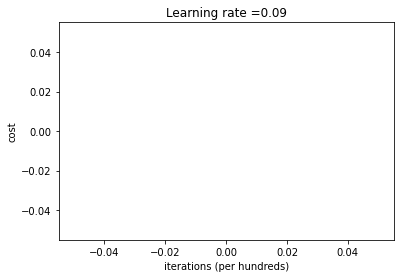

In [32]:
def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
#winner - .14
parameters, costs = L_layer_nn(train_df, train_labels, layer_dims, learning_rate=.041, num_iterations=100000)
plot_costs(costs, learning_rate=.09)

Let's write a quick prediction function to see how our model is performing.

In [33]:
def predict(X, Y, parameters):
    """
    Predicts results of a L-layer neural network.
    Args:
    X: data set of examples being predicted
    Y: true labels
    parameters: parameters of the trained model
    Returns:
    predictions: predictions of the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = nn_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    print("Accuracy: "+str(np.sum((p == Y) / m)))
    
    return p

In [34]:
pred_train = predict(train_df, train_labels, parameters)

Accuracy: 0.6161616161616161
